In [26]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy
import en_core_web_sm
import textacy.extract

import nltk
from nltk import FreqDist
from nltk import wordpunct_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from PIL import Image
from wordcloud import WordCloud,STOPWORDS

import gensim
import pyLDAvis
from gensim import corpora, models
from pyLDAvis import gensim as gnsm

from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

In [27]:
# Loading dataframe with reviews

df = pd.read_csv('data/BA_reviews.csv')

# Data analysis

In [28]:
# Removing the non-informative column and verification information from the reviews text

df = df.drop(columns='Unnamed: 0')
for i in range(0, len(df)):
    try:
        df.loc[i, 'reviews'] = df.loc[i, 'reviews'].split('|')[1]
    except:
        pass

In [29]:
df.head(3)

,reviews
0,Worst experience ever. Outbound flight was ca...
1,"Check in was a shambles at BWI, just 3 count..."
2,Beyond disgusted with the fact that my baggag...


In [30]:
# Creating stop-words dictionaries

englishStopWords = set(nltk.corpus.stopwords.words('english'))
nonEnglishStopWords = set(nltk.corpus.stopwords.words()) - englishStopWords
stopWordsDictionary = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}

In [31]:
# Function to determine the dominant language in reviews

def get_language(text):
    if type(text) is str:
        text = text.lower()
    words = set(nltk.wordpunct_tokenize(text))
    return max(((lang, len(words & stopwords)) for lang, stopwords in stopWordsDictionary.items()), key = lambda x: x[1])[0]

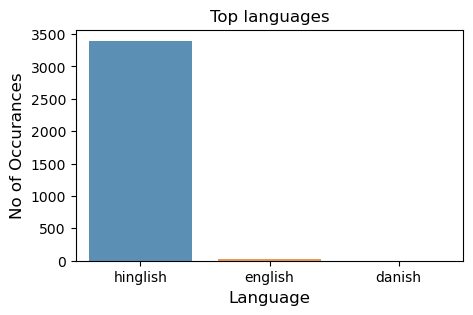

In [32]:
# Determining the dominant language and plotting the distribution of top languages in reviews

df['language'] = df['reviews'].apply(get_language)
language_count = df['language'].value_counts()
language_count = language_count[:5]

plt.figure(figsize = (5,3))
sns.barplot(language_count.index, language_count.values, alpha = 0.8)
plt.title('Top languages')
plt.ylabel('No of Occurances', fontsize = 12)
plt.xlabel('Language', fontsize = 12)
plt.show()

In [33]:
# Place reviews in English in the new dataframe

english_reviews_df = df[df['language'] != 'danish']
english_reviews_df = english_reviews_df['reviews']

# Creating wordcloud

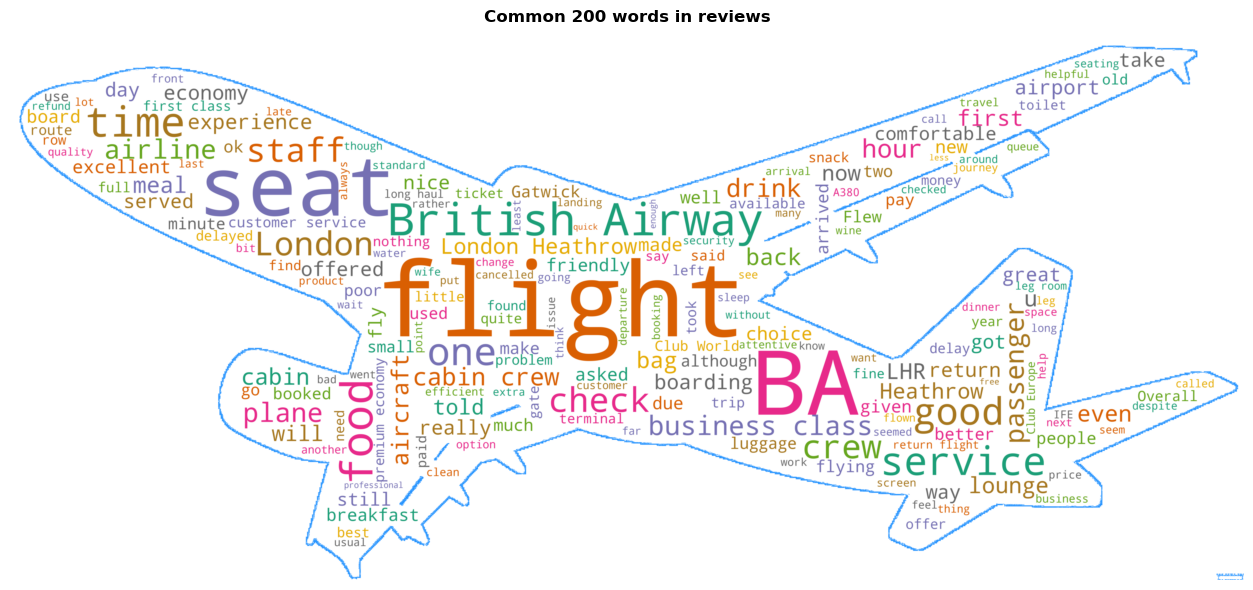

In [110]:
# Create a wordcloud

def showWordCloud(data):
    unite_reviews = ' '.join(data)
    cleaned_reviews = ' '.join([word for word in unite_reviews.split()])
    plane_mask = np.array(Image.open("plane.png"))
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color='white', 
                          mask=plane_mask, max_words=200, 
                          contour_width=3, contour_color='dodgerblue',
                          colormap='Dark2'
                         ).generate(cleaned_reviews)
    plt.figure(figsize = (20,7))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('Common 200 words in reviews', pad = 14, weight = 'bold')
    plt.show();
    
showWordCloud(english_reviews_df)

# Sentiment analysis

In [ ]:
# Sentiment analysis using a pipeline from the Transformers library by Hugging Face

sentiment_pipeline = pipeline(model="siebert/sentiment-roberta-large-english")
reviews_sentiments = pd.DataFrame.from_dict(sentiment_pipeline(cleaned_reviews_list))

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at siebert/sentiment-roberta-large-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


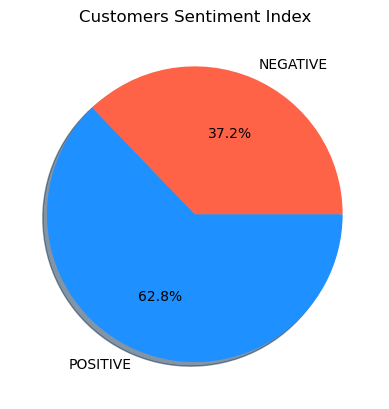

In [11]:
# Client sentiment chart output

plt.pie(reviews_sentiments.label.value_counts(), colors=['dodgerblue', 'tomato'], 
        labels=['POSITIVE', 'NEGATIVE'], autopct='%1.1f%%', counterclock=False, shadow=True)
plt.title('Customers Sentiment Index')
plt.show();

# Analysis of customer opinions about British Airways - extracting information

In [111]:
# Analysis of the context in which customers mentioned British Airways

# Loading the NLP model
nlp = en_core_web_sm.load()

# Using the loop, the model will parse the text in parts, since there is a limit on the number of incoming characters
# The analysis is performed on two phrases 'British Airways' and 'BA'
print('What people say about British Airways:\n')
for i in range(0, 7):
    text = ' '.join(map(str,english_reviews_df.tolist()[i * 500:(i + 1) * 500]))
    doc = nlp(text)
    statements_1 = textacy.extract.semistructured_statements(doc, entity=re.compile('british airways', re.IGNORECASE), cue=('be'))
    statements_2 = textacy.extract.semistructured_statements(doc, entity=re.compile('ba', re.IGNORECASE), cue=('be'))
    for statement in statements_1:
        subject, verb, fact = statement
        print(f' - {" ".join(map(str,fact))}')
    for statement in statements_2:
        subject, verb, fact = statement
        print(f' - {" ".join(map(str,fact))}')

What people say about British Airways:
 - the worst air company I have ever flown with
 - their partner airline
 - the most terrible airline I ’ve dealt with
 - the most terrible airline I ’ve ever dealt with
 - a great airline
 - a glorified budget airline
 - one of the few commercial carriers in the world that charges an exorbitant amount in fees when booking travel
 - the main operator at Heathrow T5
 - the best operator from Ulster to England
 - a game of two halves
 - the bottom of the pile and reluctantly the last one I would use
 - the worst and
 - a waste of my money
 - the airline they once were
 - my last choice of an airline
 - my first priority
 - my favorite airline
 - a rip off
 - a disgrace of an airline
 - a premium carrier
 - the return leg from Madrid to London Heathrow
 - the only one flying 747s to Europe from Seattle )
 - a low cost airline
 - how much behind the play
 - AA partner
 - a disgrace for a once proud airline
 - a disgrace
 - the lowest cost option on th

# Topic modeling

In [9]:
# Creating a function for removing punctuations, stopwords, tokenization and lemmatization

lemmatizer = WordNetLemmatizer()

def clean_text(data):
    cleaned_text = []
    stopword = stopwords.words('english')

    for text in data:
        text = str(text).lower()
        text = re.sub(r'[^\w ]+', '', text)
        text = ' '.join([lemmatizer.lemmatize(word,pos='v') for word in word_tokenize(text) if not word in set(stopword) and len(word)>3])
        cleaned_text.append(text)        
    return cleaned_text

cleaned_reviews_list = clean_text(english_reviews_df.tolist())

In [21]:
# Creating a function to display the most frequent words

def words_frequency(text, top_n = 20):
    words = ' '.join([sent for sent in text])
    words = words.split()
    freq_dist = FreqDist(words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
  
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns='count', n=top_n) 
    plt.figure(figsize=(15,8))
    ax = sns.barplot(data=d, x='word', y='count')
    ax.set(ylabel='Count')
    plt.show();

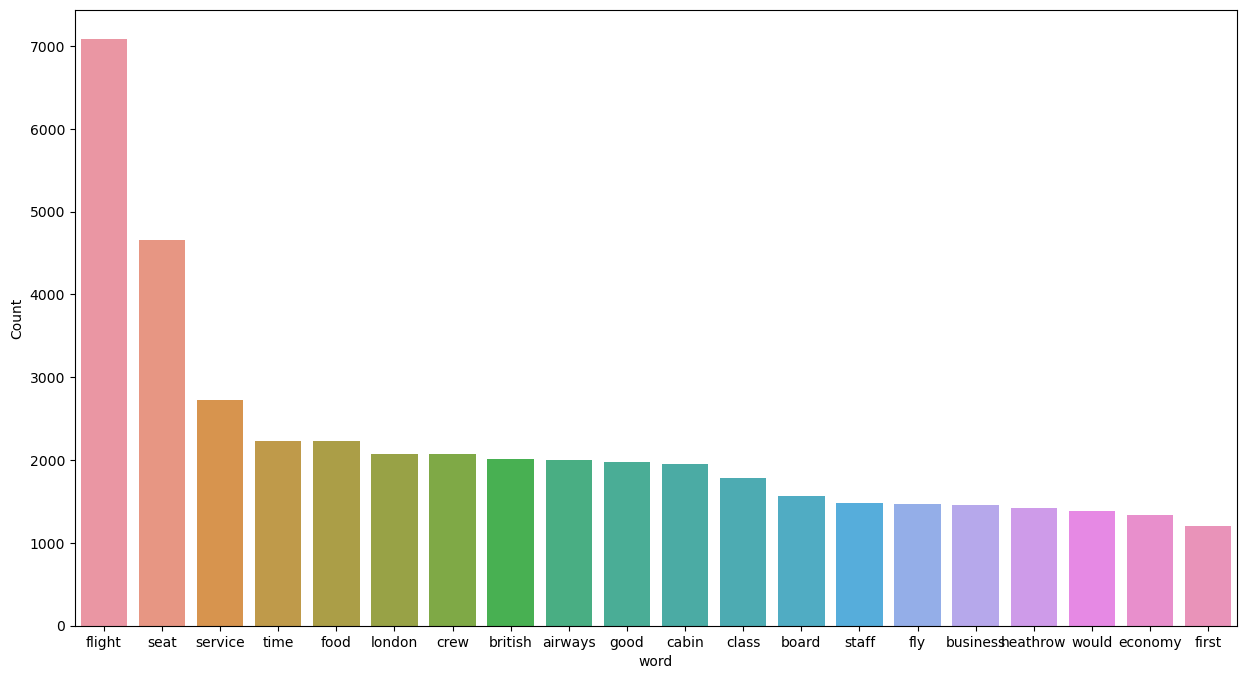

In [22]:
words_frequency(cleaned_reviews_list)

In [12]:
### Creating function to get biograms

def make_biagram(data,tokens):
    bigram = gensim.models.Phrases(data, min_count=10, threshold=500)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in tokens]  

In [20]:
# Topic modeling

tokens = []
for text in cleaned_reviews_list:
    text = word_tokenize(text)
    tokens.append(text)
        
    tokens = make_biagram(data=cleaned_reviews_list,tokens=tokens)

dictionary = corpora.Dictionary(tokens)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokens]

lda_model =  models.LdaModel(doc_term_matrix,
                             num_topics = 5,
                             id2word = dictionary,                               
                             passes = 10,        
                             chunksize=50,       
                             update_every=1,     
                             alpha='auto',      
                             per_word_topics=True,
                             random_state=42)

for idx, topic in lda_model.print_topics():
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.063*"flight" + 0.016*"time" + 0.015*"staff" + 0.013*"would" + 0.012*"back" + 0.012*"check" + 0.010*"board" + 0.009*"take" + 0.009*"hours" + 0.009*"service"


Topic: 1 
Words: 0.057*"fast" + 0.034*"track" + 0.031*"special" + 0.027*"june" + 0.019*"domestic" + 0.009*"taxi" + 0.009*"five" + 0.009*"desire" + 0.008*"assign" + 0.008*"remote"


Topic: 2 
Words: 0.037*"call" + 0.027*"book" + 0.023*"customer" + 0.021*"tell" + 0.015*"cancel" + 0.011*"ticket" + 0.011*"receive" + 0.011*"explanation" + 0.010*"july" + 0.010*"august"


Topic: 3 
Words: 0.045*"seat" + 0.023*"food" + 0.022*"good" + 0.021*"crew" + 0.019*"cabin" + 0.013*"class" + 0.013*"club" + 0.013*"service" + 0.012*"flight" + 0.010*"economy"


Topic: 4 
Words: 0.020*"fly" + 0.018*"airlines" + 0.015*"airline" + 0.010*"years" + 0.009*"haul" + 0.009*"dont" + 0.009*"money" + 0.009*"extra" + 0.009*"awful" + 0.009*"poor"




In [24]:
# Jupyter Notebook page alignment

from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

In [34]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = gnsm.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.display(vis)